### Classification Model to determine which features affect if the tasker would be hired

In [61]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# imbalance class control
from imblearn.over_sampling import SMOTE

# Cross Validating
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# model
from sklearn.ensemble import GradientBoostingClassifier

# model evaluation
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
 

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import rfpimp

In [62]:
df = pd.read_csv('data/taskrabbitdata.csv')
df.head(2)

,recommendation_id,created_at,tasker_id,position,hourly_rate,num_completed_tasks,hired,category
0,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1009185352,1,38,151,0,Furniture Assembly
1,0-0-70cf97d7-37af-4834-901c-ce3ad4893b8c,2017-09-01 00:32:25,1006892359,2,40,193,0,Furniture Assembly


#### Selecting the following features for our classifier:

In [63]:
model_data = df[['position','hourly_rate', 'num_completed_tasks', 'hired']]
model_data.head(2)

,position,hourly_rate,num_completed_tasks,hired
0,1,38,151,0
1,2,40,193,0


### Dependent and Independent Variables:
* y - dependent variable 'hired'.
* Independent variables (X): 'position', 'hourly rate', 'number completed tasks'

#### Splitting Data on training and testing set:

In [64]:
y = model_data.hired
X = model_data.drop('hired', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, y_train.shape

((22500, 3), (22500,))

Using **SMOTE** (Synthetic Minority Oversampling Technique) to balance the under represented class (hired is only 5% of total observations)
We are only using SMOTE on the training set, not the validation/test set

In [65]:
sm = SMOTE(random_state=42, ratio=1.0)
X_train, y_train = sm.fit_sample(X_train, y_train)

SMOTE generated additional samples for the training set

In [75]:
X_train.shape, y_train.shape

((42410, 3), (42410,))

Building classifier model  using **GradienBoostingClassifier**:

In [85]:
model = GradientBoostingClassifier(loss='deviance', learning_rate=0.07, 
                                   n_estimators=37, max_depth = 5).fit(X_train, y_train)
y_pred = model.predict(X_test)


Recall Score: 0.6878
Model Accuracy:  0.7977


#### Evaluating the model

In [89]:
print('Recall Score:', round(recall_score(y_test, y_pred),4 ))
print('Model Accuracy: ', round(accuracy_score(y_test, y_pred), 4))
print('Confusion Matrix:')
pd.DataFrame(confusion_matrix(y_test, y_pred))

Recall Score: 0.6878
Model Accuracy:  0.7977
Confusion Matrix:


,0,1
0,5701,1389
1,128,282


#### It's a workable _baseline model_ to help us classify if the tasker is being hired    
* We have low number of FN (when tasker is not hired but we predict she'll be hired)

Text(33.0, 0.5, 'predicted')

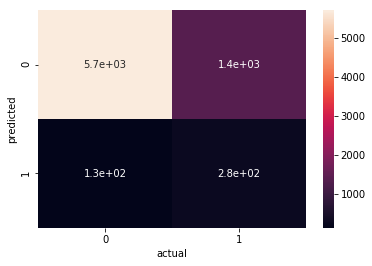

In [30]:
#same with better visuals
# Evaluating on y_test
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot= True)
plt.xlabel('actual')
plt.ylabel('predicted')

AUC: 0.807


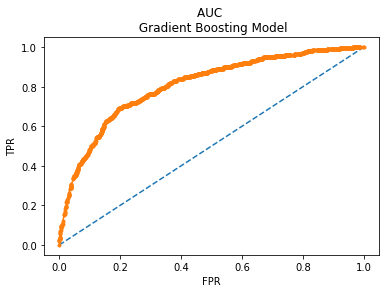

In [91]:
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
 # calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.title('AUC \n Gradient Boosting Model')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

#### Partial Dependence Plots

* Tasker 'Position' is heavily influencing the outcome.
* From the plot we can't say that 'Hourly Rate' up to **100** is influencing the outcome/ However, once it reaches $100 and up it negatively affecting the outcome (towards not hired)
* Number of tasks growing and with then ''Number of Tasks' above ~350 the plot stays above zero. We will use number 350 tasks (which is also around 25th top tasker numebr of completed tasks (see EDA) to define Super Pro-Tasker).

<Figure size 1440x1440 with 0 Axes>

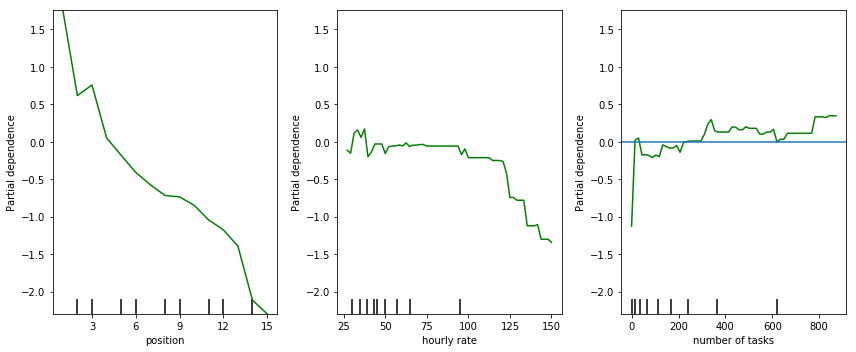

In [92]:
plt.figure(figsize = (20, 20))
fig, ax = plot_partial_dependence(model,       
                                   features=[0,1,2], # column numbers of plots we want to show
                                   X=X,            # raw predictors data.
                                   feature_names=['position', 'hourly rate', 'number of tasks'], # labels on graphs
                                   grid_resolution=60, percentiles=(0.05, 0.95)) # number of values to plot on x axis

fig.set_figwidth(12)
fig.set_figheight(5)
fig.tight_layout()
plt.axhline(y = 0)

#### Another look at the features importance using permutation importance:
* Reconfirming that position is the leading predictor for our classifier, followed by number of tasks. Hourly rate does not affect the outcome as much as the other two predictors. 

In [41]:
def perumation_importance( X_test, y_test):

        pimp_imps = rfpimp.importances(model, X, y)
        rfpimp.plot_importances(pimp_imps, yrot=0,
                                label_fontsize=12,
                                width=12,
                                minheight=2,
                                vscale=2.0,
                                imp_range=(0, pimp_imps['Importance'].max() + .01),
                                color='#484c51',
                                bgcolor='#F1F8FE',  
                                xtick_precision=2,
title='Permutation Importances')

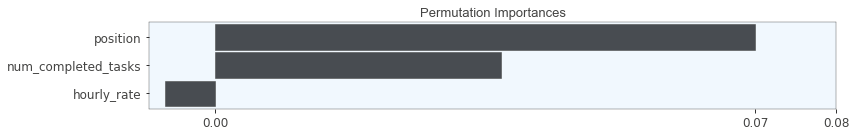

In [42]:
perumation_importance(X_test, y_test)

#### Conclusion:
* Determined that Position is the leading feature. The higher the position the higher the chance to be hired. 
* Determined that at around 350+ tasks classifier shifts to positive values 
* Hourly Rate not a strong predictor, however, when it's > $100 plot starts to decrease towards not hired.
